In [ ]:
import cv2
import os
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

print(f"Usando OpenCV versão: {cv2.__version__}")

from google.colab.patches import cv2_imshow

Usando OpenCV versão: 4.12.0


# Detecção e Extração de Características

In [ ]:
os.makedirs("images", exist_ok=True)
uploaded = files.upload()  # selecione múltiplas imagens
for fn in uploaded.keys():
    os.rename(fn, f"images/{fn}")

Saving IMG_1070.jpeg to IMG_1070.jpeg
Saving IMG_1069.jpeg to IMG_1069.jpeg
Saving IMG_1068.jpeg to IMG_1068.jpeg
Saving IMG_1067.jpeg to IMG_1067.jpeg
Saving IMG_1066.jpeg to IMG_1066.jpeg


In [ ]:
# Pega os nomes dos arquivos dentro da pasta images
img_names = [x for x in os.listdir("images") if x.endswith(('.jpeg', '.jpg', '.png'))]

# --- LÓGICA DE ORDENAÇÃO NUMÉRICA ---
def extrair_numero(nome_do_arquivo):
    try:
        parte_sem_extensao = nome_do_arquivo.split('.')[0]
        numero_str = parte_sem_extensao.split('_')[1]  # ex: img_1.jpg -> pega "1"
        return int(numero_str)
    except:
        return -1

# Usa a função como chave para a ordenação (1, 2, 3...)
img_names.sort(key=extrair_numero)
# --- FIM DA LÓGICA DE ORDENAÇÃO ---

# Imprime a lista final para conferir
print("Ordem de arquivos corrigida (esquerda para a direita):")
print(img_names)

# Monta os caminhos completos para carregar com OpenCV
images = [cv2.imread(os.path.join("images", nome)) for nome in img_names]
images_cinza = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

print(f"\nCarregadas {len(images)} imagens na ordem correta para a montagem.")

Ordem de arquivos corrigida (esquerda para a direita):
['IMG_1066.jpeg', 'IMG_1067.jpeg', 'IMG_1068.jpeg', 'IMG_1069.jpeg', 'IMG_1070.jpeg']

Carregadas 5 imagens na ordem correta para a montagem.


##SIFT

In [ ]:
"""
SIFT parameters
nfeatures:	Limits the max number of strongest keypoints returned. If too high, too many points; lower it to reduce keypoints.
contrastThreshold:	Higher values reduce keypoints in low-contrast areas. Default 0.04. Increase to detect fewer points.
edgeThreshold	Controls: edge response filtering. Higher values allow more edge points; lower removes edge-like keypoints.
nOctaveLayers:	More layers = finer scale-space detection; can increase number of keypoints slightly.
sigma:	Initial Gaussian blur. Larger sigma smooths image, reducing noise and small keypoints.
"""
sift = cv2.SIFT_create(
    nfeatures=5000,          # Maximum number of keypoints to retain
    nOctaveLayers=3,         # Number of layers in each octave (affects scale space granularity)
    contrastThreshold=0.04,  # Minimum contrast for keypoints
    edgeThreshold=10,        # Minimum edge response (reduces edge keypoints)
    sigma=1.2                # Gaussian smoothing applied at first octave
)

"""
Contains sift (keypoints, desc)
sift = lista de tuplas:
sift[0][0] = keypoint da imagem 0
sift[0][1] = descriptor da imagem 0
sift[1][0] = keypoint da imagem 1 (...)
"""
sift = [sift.detectAndCompute(im, None) for im in images_cinza]

Number of keypoints found: 424


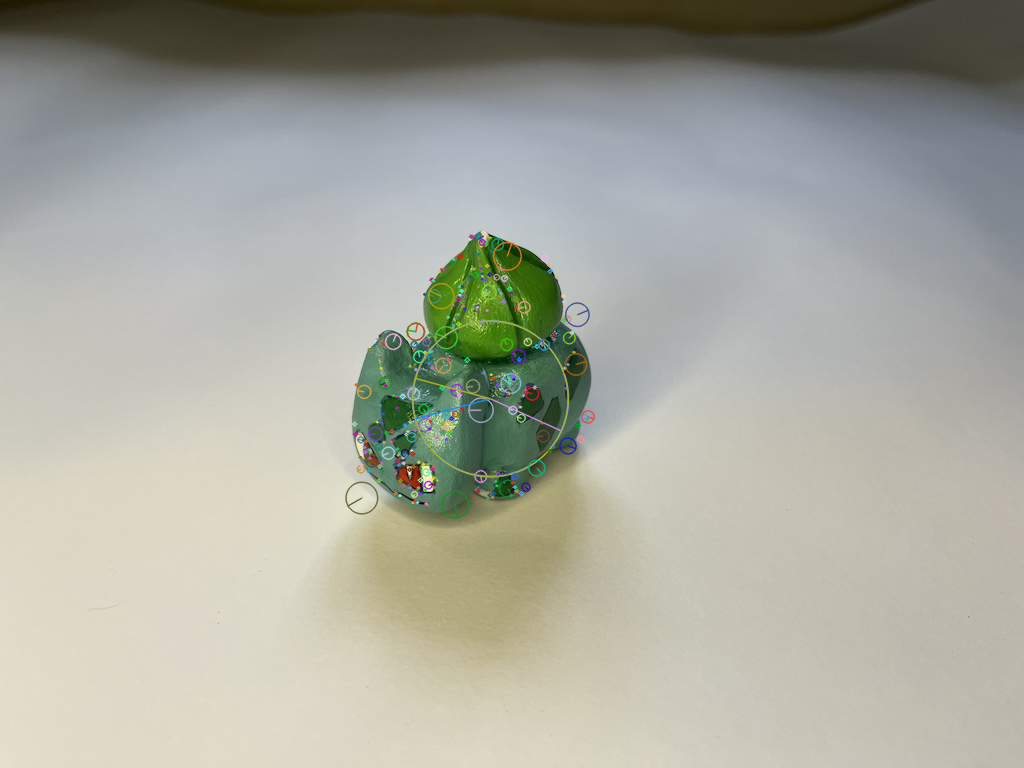

In [ ]:
"""
cv2.drawKeypoints(image, keypoints, outImage, color=None, flags=0) draws keypoints on an image.
Parameters:
image: Original BGR image.
keypoints: List of detected keypoints.
outImage: Output image. None means OpenCV creates a copy.
flags: How keypoints are drawn. Key options:
  cv2.DRAW_MATCHES_FLAGS_DEFAULT: Simple small circle.
  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: Draws size and orientation of keypoints (circles with lines).
  cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS: Ignores points with low response.
"""

img_sift = cv2.drawKeypoints(images[0], sift[0][0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(f"Number of keypoints found: {len(sift[0][0])}")
cv2_imshow(img_sift)

##ORB

In [ ]:
"""
ORB parameters
nfeatures:	Maximum number of keypoints returned. Higher = more points.
scaleFactor:	Scale pyramid factor. Each level is prev_level / scaleFactor. Smaller factor → more levels → more keypoints.
nlevels:	Number of pyramid levels. More levels → detects features at more scales.
edgeThreshold:	Margin around image where keypoints are ignored. Prevents keypoints too close to edges.
firstLevel:	Base level of pyramid. Usually 0.
WTA_K:	Number of points used for computing BRIEF descriptor (2,3,4). Higher = more distinctive but slower.
scoreType:	How keypoints are ranked:
  cv2.ORB_HARRIS_SCORE → uses Harris corner score.
  cv2.ORB_FAST_SCORE → uses FAST score. |
  | patchSize | Size of patch around keypoint for descriptor computation. Larger = more context, slower. |
  | fastThreshold | Threshold for FAST corner detection. Higher → fewer keypoints; lower → more keypoints. |
"""
orb = cv2.ORB_create(
    nfeatures=5000,        # Max number of keypoints to retain
    scaleFactor=1.2,       # Pyramid decimation ratio between levels
    nlevels=4,             # Number of pyramid levels
    edgeThreshold=31,      # Size of border to ignore edges
    firstLevel=0,          # Index of first pyramid level
    WTA_K=2,               # Number of points for BRIEF descriptor (2,3,4)
    scoreType=cv2.ORB_HARRIS_SCORE,  # Method to rank keypoints
    patchSize=31,          # Size of patch used by BRIEF descriptor
    fastThreshold=20       # Threshold for FAST keypoint detection
)

# Contains orb (keypoints, desc)
orb = [orb.detectAndCompute(im, None) for im in images_cinza]

Number of keypoints found: 1426


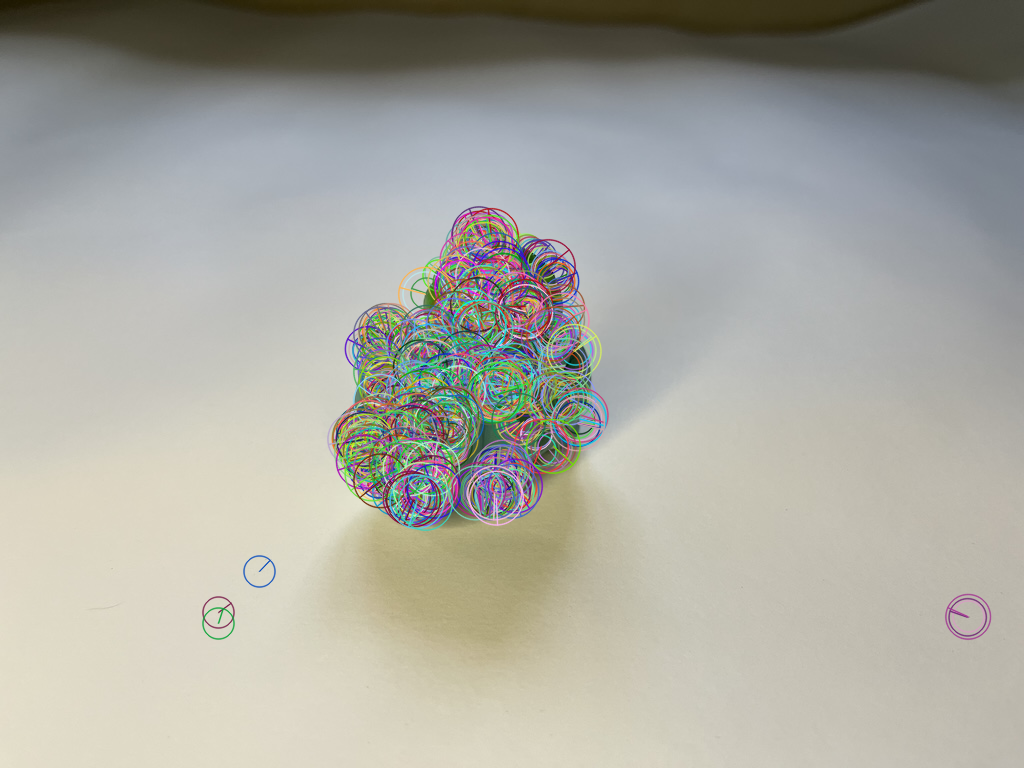

In [ ]:
img_orb = cv2.drawKeypoints(images[0], orb[0][0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(f"Number of keypoints found: {len(orb[0][0])}")
cv2_imshow(img_orb)

#Emparelhamento

Brute-Force Matcher

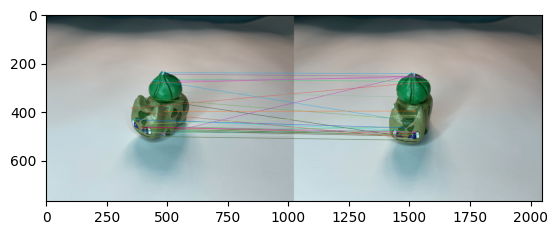

(<matplotlib.image.AxesImage at 0x7e74eb3fe5a0>, None)

In [ ]:
"""
Brute-Force Matcher

Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation.
And the closest one is returned.

Lets take as an example images 1 and 2

"""

# BFMatcher with default params
bf = cv2.BFMatcher()
# Corrected indices to access the first two images (index 0 and 1)
matches = bf.knnMatch(sift[0][1], sift[1][1], k=2)

# Apply LOWE'S RATIO TEST
good = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
# Corrected indices for images and sift to match the first two images
matched_image = cv2.drawMatchesKnn(images[0], sift[0][0], images[1], sift[1][0], good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matched_image),plt.show()

FLANN

In [ ]:
"""
FLANN = Fast Library for Approximate Nearest Neighbors, optimized for large datasets and high-dimensional descriptors.

For FLANN based matcher, we need to pass two dictionaries which specifies the algorithm to be used, its related parameters etc.

Parameters:
  algorithm=1 → KD-tree (best for SIFT/SURF descriptors).
  trees=5 → number of KD-trees in the index (more trees = higher accuracy, slower).
  checks=50 → number of times to check trees for nearest neighbors (higher = more accurate, but takes more time).
"""
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

"""
knnMatch() finds the two nearest neighbors for each descriptor.
We use k=2 because Lowe’s ratio test requires two closest matches.

A descriptor is a numerical vector that describes the local image patch around a keypoint.
For SIFT, each descriptor is 128-dimensional.
Descriptors encode scale, orientation, and gradient information, so that we can compare keypoints across images.

matches = flann.knnMatch(des1, des2, k=2)
des1 → descriptors from image 1
des2 → descriptors from image 2
flann.knnMatch() compares all vectors in des1 to all vectors in des2 and finds the closest matches using Euclidean distance.
"""
matches = []
for i in range(len(sift) - 1):
  mtchs = flann.knnMatch(sift[i][1], sift[i + 1][1], k = 2) # Total matches
  # LOWE'S TEST ROTATION
  """
  m = best match, n = second-best match.
  m.distance = Euclidean distance between descriptors.
  Ratio test keeps matches where best match is significantly closer than second-best.
  Threshold 0.7 is typical (adjustable).
  """
  good_matches = []
  for m, n in mtchs:
      if m.distance < 0.6 * n.distance:
          good_matches.append(m)

  print(f"{i} and {i+1} Good matches after ratio test: {len(good_matches)}")
  matches.append(good_matches)

0 and 1 Good matches after ratio test: 12
1 and 2 Good matches after ratio test: 64
2 and 3 Good matches after ratio test: 55
3 and 4 Good matches after ratio test: 2


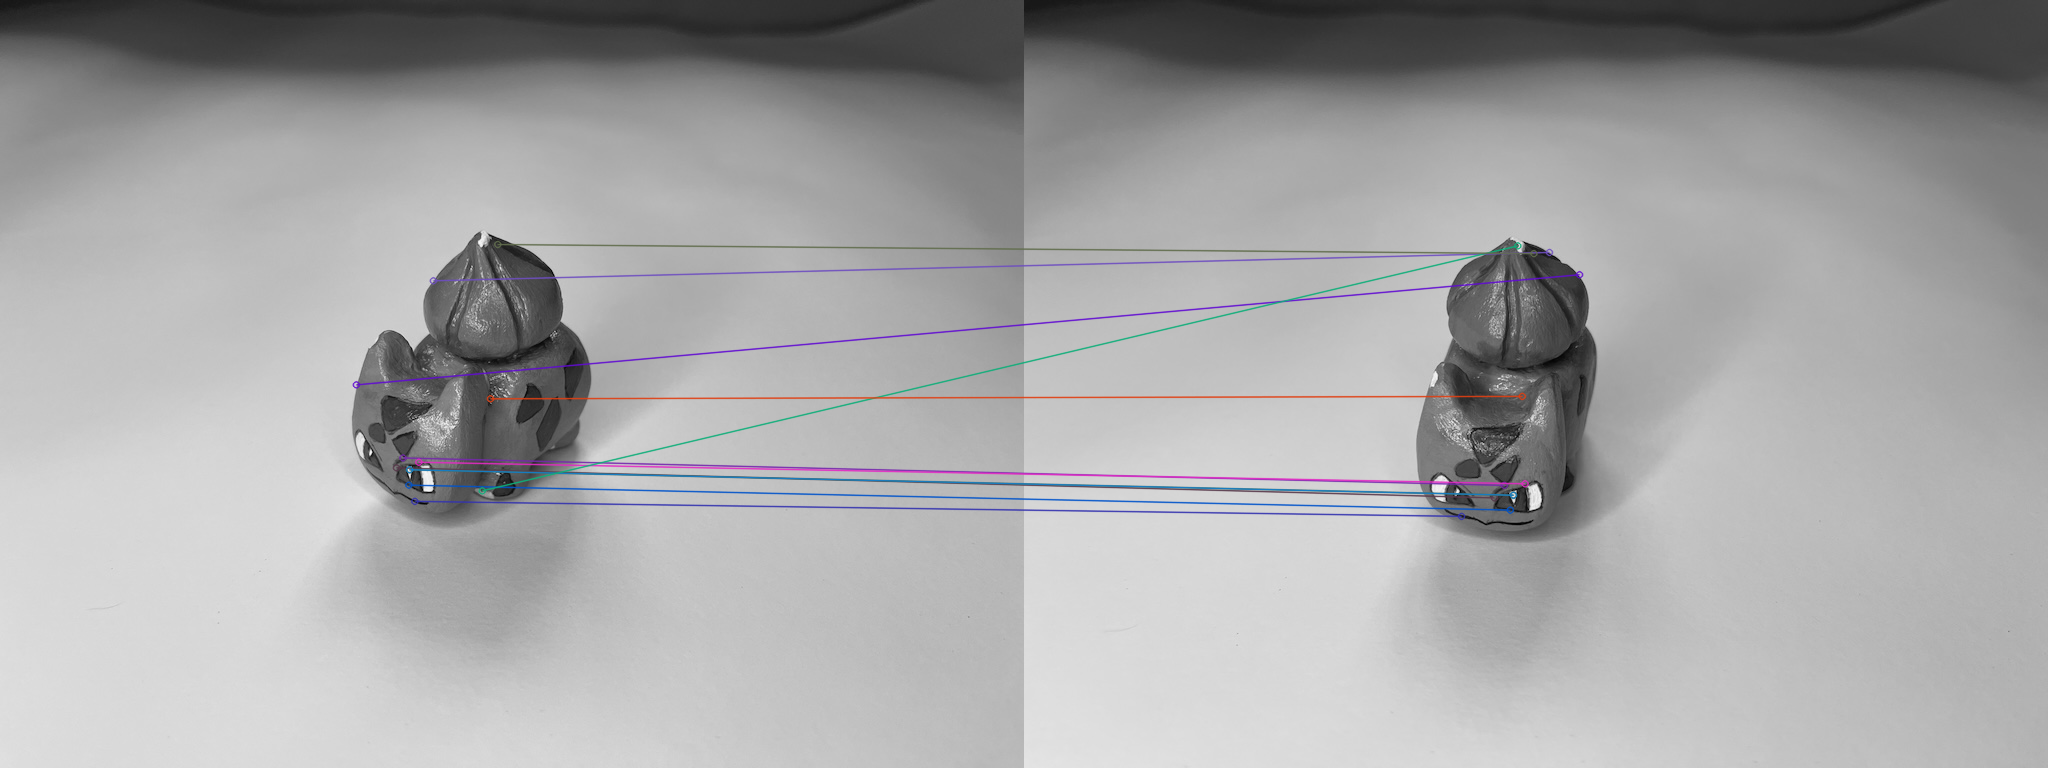

In [ ]:
img_matches = cv2.drawMatches(
    images_cinza[0], sift[0][0],
    images_cinza[1], sift[1][0],
    matches[0], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
"""
cv2.drawMatches() draws lines connecting matching keypoints.
flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS → only draws matched keypoints, not all keypoints.
"""
cv2_imshow(img_matches)

Estimando a Matriz Fundamental F com RASNAC

Inliers: 17 / 36


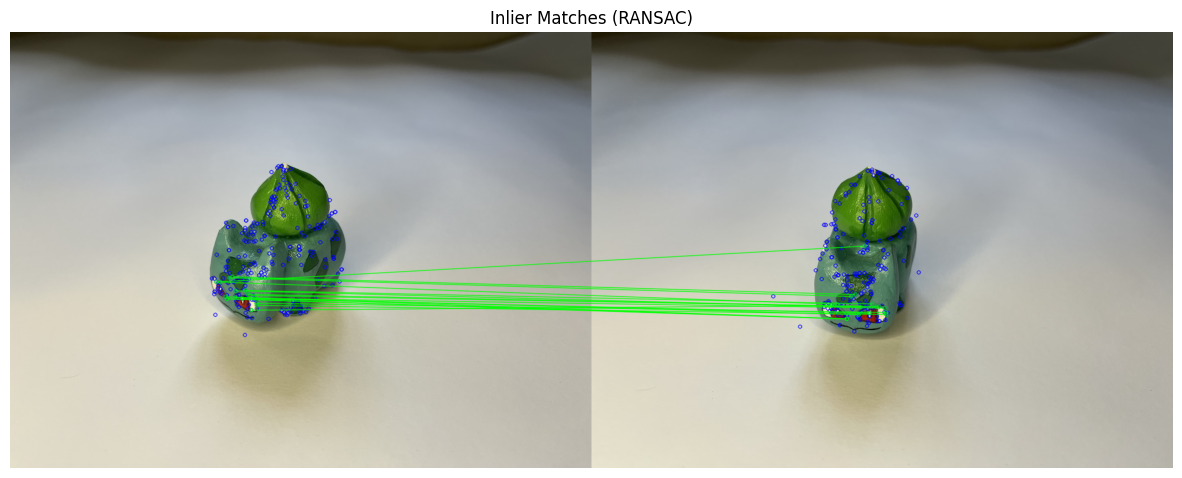

In [ ]:
# Fazendo para duas imagens
img1 = cv2.imread(f"images/{images[0]}")
img2 = cv2.imread(f"images/{images[1]}")

# Detectar e descrever com SIFT
sift = cv2.SIFT_create()
kp1, desc1 = sift.detectAndCompute(images_cinza[0], None)
kp2, desc2 = sift.detectAndCompute(images_cinza[1], None)

# Matching bruto com FLANN
index_params = dict(algorithm=1, trees=5)  # KD-tree
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc1, desc2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good.append(m)

pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

# Estimar Fundamental com RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold = 1.0)
inliers1 = pts1[mask.ravel()==1]
inliers2 = pts2[mask.ravel()==1]

print(f"Inliers: {len(inliers1)} / {len(pts1)}")

# Desenhar alguns matches inliers
img_matches = cv2.drawMatches(images[0], kp1, images[1], kp2,
                              [g for i,g in enumerate(good) if mask[i]==1],
                              None, matchColor=(0,255,0), singlePointColor=(255,0,0))
plt.figure(figsize=(15,7))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Inlier Matches (RANSAC)")
plt.axis("off")
plt.show()

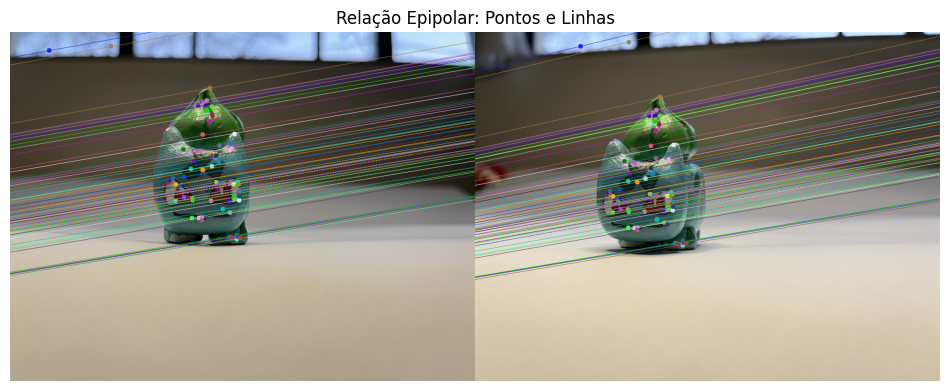

In [ ]:

def draw_epilines_and_matches(img1, img2, pts1, pts2, F):
    # Calcula as epilines para pts1 (na img1) em img2
    lines1 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F).reshape(-1, 3)

    # Calcula as epilines para pts2 (na img2) em img1
    lines2 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F).reshape(-1, 3)

    # Cria cópias das imagens para desenhar
    img1_out = img1.copy()
    img2_out = img2.copy()

    r, c = img1.shape[:2]

    for i in range(len(pts1)):
        # Gera uma cor aleatória para cada par de pontos e linhas
        color = tuple(np.random.randint(0, 255, 3).tolist())

        # Desenha o ponto em ambas as imagens
        cv2.circle(img1_out, tuple(np.int32(pts1[i])), 5, color, -1)
        cv2.circle(img2_out, tuple(np.int32(pts2[i])), 5, color, -1)

        # Desenha a epiline para o ponto de img1 na img2
        a, b, c_ = lines1[i]
        x0_img2, y0_img2 = map(int, [0, -c_ / b])
        x1_img2, y1_img2 = map(int, [c, -(c_ + a * c) / b])
        cv2.line(img2_out, (x0_img2, y0_img2), (x1_img2, y1_img2), color, 1)

        # Desenha a epiline para o ponto de img2 na img1
        a, b, c_ = lines2[i]
        x0_img1, y0_img1 = map(int, [0, -c_ / b])
        x1_img1, y1_img1 = map(int, [c, -(c_ + a * c) / b])
        cv2.line(img1_out, (x0_img1, y0_img1), (x1_img1, y1_img1), color, 1)

    # Concatena as duas imagens lado a lado para visualização
    return np.hstack((img1_out, img2_out))

# Chame a nova função de visualização
final_vis = draw_epilines_and_matches(images[0], images[1], inliers1, inliers2, F)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(final_vis, cv2.COLOR_BGR2RGB))
plt.title("Relação Epipolar: Pontos e Linhas")
plt.axis("off")
plt.show()

Encontrando a Matriz Essencial com RASNAC e recuperando a poses da câmeras

In [ ]:
# Supondo câmera calibrada (para simplicidade, matriz identidade)
K = np.array([[1000, 0, images[0].shape[1]/2],
              [0, 1000, images[1].shape[0]/2],
              [0, 0, 1]])

# Encontrando a Matriz Essencial
E, _ = cv2.findEssentialMat(inliers1, inliers2, K, method=cv2.RANSAC)

# Recuperanso a pose da câmera
_, R, t, _ = cv2.recoverPose(E, inliers1, inliers2, K)
print("R =\n", R)
print("t =\n", t.ravel())

R =
 [[ 0.98070417  0.01419111  0.1949819 ]
 [-0.0045051   0.99873753 -0.0500304 ]
 [-0.19544573  0.04818661  0.97953   ]]
t =
 [-0.94666735  0.26024565  0.18998194]


Triangulando pontos 3D iniciais

In [ ]:
# Triangular alguns pontos inliers
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R, t))
pts1_norm = cv2.undistortPoints(inliers1.reshape(-1,1,2), K, None)
pts2_norm = cv2.undistortPoints(inliers2.reshape(-1,1,2), K, None)
pts4d = cv2.triangulatePoints(P1, P2, pts1_norm, pts2_norm)
pts3d = (pts4d[:3] / pts4d[3]).T
print("Primeiros pontos 3D:\n", pts3d[:5])

print("Número de pontos 3D triangulados:", pts3d.shape)


Primeiros pontos 3D:
 [[-2.0913448 -1.6665413  4.0182705]
 [-2.090746  -1.6665255  4.018182 ]
 [-2.0884404 -1.6638638  4.01472  ]
 [-2.0884194 -1.6638273  4.0146966]
 [-2.088403  -1.6637131  4.0147004]]
Número de pontos 3D triangulados: (83, 3)


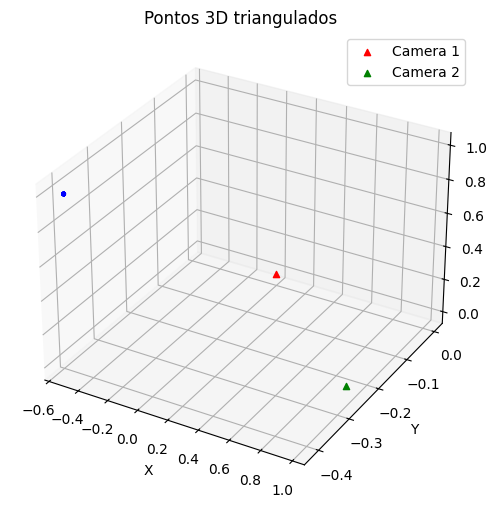

In [ ]:
# Visualização da triangulação
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Seus pontos 3D (já normalizados em pts3d)
pts3d = (pts4d[:3] / pts4d[3]).T

# filtrando os Z positivo (na frente da camera)
pts3d = pts3d[pts3d[:,2] > 0]

# escala para melhorar visualização
pts3d /= np.max(np.abs(pts3d))  # normaliza entre -1 e 1


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar os pontos
ax.scatter(pts3d[:, 0], pts3d[:, 1], pts3d[:, 2], c='b', s=5)

# Opcional: marcar origem da primeira câmera
ax.scatter(0, 0, 0, c='r', marker='^', label='Camera 1')
# E a posição da segunda câmera (em -R.T * t)
cam2_pos = -R.T @ t
ax.scatter(cam2_pos[0], cam2_pos[1], cam2_pos[2], c='g', marker='^', label='Camera 2')

ax.set_title("Pontos 3D triangulados")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()
